#  RNN FOR STOCK  PRICE PREDICTION

```
# This is formatted as code
```



# Loading the data

In [247]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, SimpleRNN, GRU, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator


In [248]:
#loading the data
test_data_df =pd.read_csv("/content/Google_Stock_Price_Test.csv")
train_data_df =pd.read_csv("/content/Google_Stock_Price_Train.csv")

In [249]:
#Displaying the first few rows of the training data
print("Training Data Head:")
print(train_data_df.head())
#Displaying the first few rows of the testing data
print("Testing Data Head:")
print(test_data_df.head())


Training Data Head:
       Date    Open    High     Low   Close      Volume
0  1/3/2012  325.25  332.83  324.97  663.59   7,380,500
1  1/4/2012  331.27  333.87  329.08  666.45   5,749,400
2  1/5/2012  329.83  330.75  326.89  657.21   6,590,300
3  1/6/2012  328.34  328.77  323.68  648.24   5,405,900
4  1/9/2012  322.04  322.29  309.46  620.76  11,688,800
Testing Data Head:
       Date    Open    High     Low   Close     Volume
0  1/3/2017  778.81  789.63  775.80  786.14  1,657,300
1  1/4/2017  788.36  791.34  783.16  786.90  1,073,000
2  1/5/2017  786.08  794.48  785.02  794.02  1,335,200
3  1/6/2017  795.26  807.90  792.20  806.15  1,640,200
4  1/9/2017  806.40  809.97  802.83  806.65  1,272,400


In [251]:
# Select relevant features
feature_columns = ['Open', 'High', 'Low', 'Close', 'Volume']

# Check for missing values in training data
print("\nMissing Values in Training Data:")
print(train_data_df[feature_columns].isnull().sum())

# Check for missing values in testing data
print("\nMissing Values in Testing Data:")
print(test_data_df[feature_columns].isnull().sum())


Missing Values in Training Data:
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Missing Values in Testing Data:
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


In [253]:
# Combine train and test data for consistent scaling
combined_df = pd.concat((train_data_df[feature_cols], test_df[feature_columns]), axis=0)

# Convert columns to numeric, removing commas
for col in feature_columns:
    combined_df[col] = pd.to_numeric(combined_df[col].astype(str).str.replace(',', ''), errors='coerce')

# Verify that there are no missing values after conversion
print("\nMissing Values After Conversion:")
print(combined_df.isnull().sum())

# Initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the combined data
scaled_combined = scaler.fit_transform(combined_df)

# Split back into scaled training and testing data
scaled_train = scaled_combined[:len(train_data_df)]
scaled_test = scaled_combined[len(train_data_df):]

# Verify the shapes
print(f"\nScaled Training Data Shape: {scaled_train.shape}")
print(f"Scaled Testing Data Shape: {scaled_test.shape}")


Missing Values After Conversion:
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Scaled Training Data Shape: (1258, 5)
Scaled Testing Data Shape: (20, 5)


# Data preprocessing
which includes the features using the close price for prediction
feature scaling:
Neural Networks perform better with the scaled data

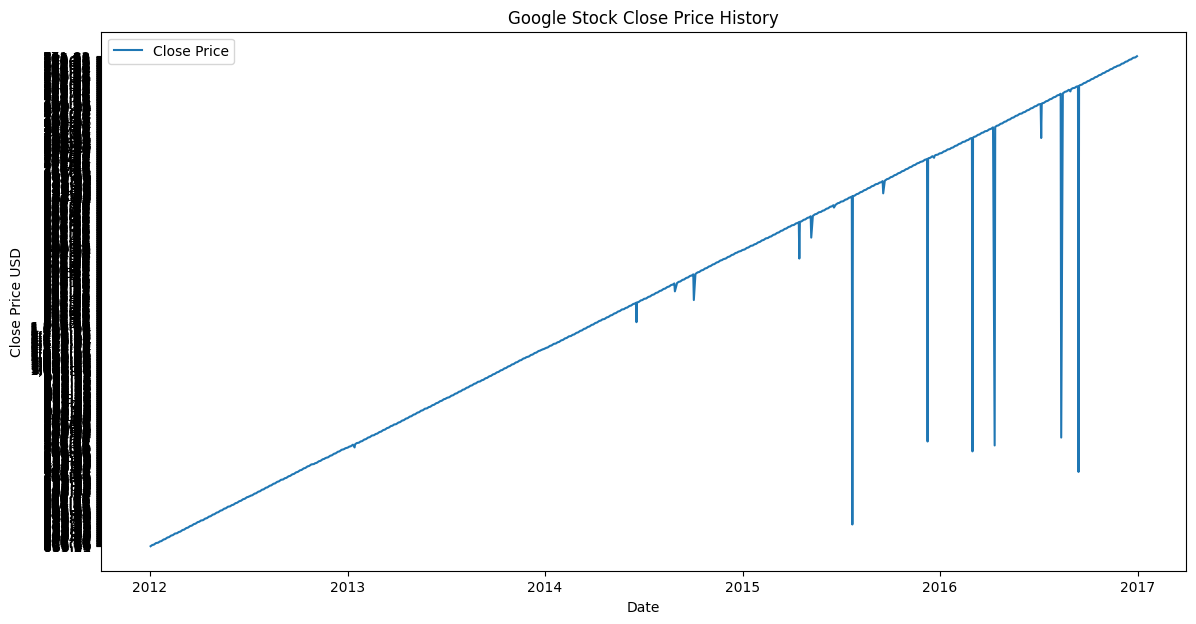

In [254]:
# Plot Closing Price History
plt.figure(figsize=(14,7))
plt.plot(pd.to_datetime(train_data_df['Date']), train_data_df['Close'], label='Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.title('Google Stock Close Price History')
plt.legend()
plt.show()


In [256]:
# 3. Creating Sequences
# Parameters
N = 30  # Number of past days
M = 1   # Number of future days to predict

# Function to create sequences
def create_sequences(Dfata, N, M):
    X, y = [], []
    for i in range(len(Dfata) - N - M + 1):
        X.append(Dfata[i:i+N])
        y.append(Dfata[i+N:i+N+M, 3])  # 'Close' price is at index 3
    return np.array(X), np.array(y)

# Split scaled_train into training and validation sets (80-20 split)
train_sized = int(len(scaled_train) * 0.8)
train_data = scaled_train[:train_sized]
val_data = scaled_train[train_sized:]

# Create sequences for training
X_train, y_train = create_sequences(train_data, N, M)

# Create sequences for validation
X_val, y_val = create_sequences(val_data, N, M)

print(f"\nX_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")



X_train shape: (976, 30, 5)
y_train shape: (976, 1)
X_val shape: (222, 30, 5)
y_val shape: (222, 1)


In [257]:
# TimeseriesGenerator for training data
train_generator = TimeseriesGenerator(
    data=train_data,
    targets=train_data[:, 3],  # Predicting 'Close' price
    length=N,
    sampling_rate=1,
    stride=1,
    batch_size=batch_size
)
# TimeseriesGenerator for validation data
val_generator = TimeseriesGenerator(
    data=val_data,
    targets=val_data[:, 3],  # Predicting 'Close' price
    length=N,
    sampling_rate=1,
    stride=1,
    batch_size=batch_size
)
print(f"\nNumber of training sequences: {len(train_generator)}")
print(f"Number of validation sequences: {len(val_generator)}")



Number of training sequences: 31
Number of validation sequences: 7


# Building the Vanilla RNN model

In [258]:
# Building the Vanilla RNN model
model_rnn = Sequential()
# Adding RNN layers
model_rnn.add(SimpleRNN(units=50, return_sequences=True, input_shape=(N, len(feature_cols))))
model_rnn.add(Dropout(0.2))
model_rnn.add(SimpleRNN(units=50, return_sequences=False))
model_rnn.add(Dropout(0.2))
# Output layer
model_rnn.add(Dense(units=M))  # Predicting 'Close' price

# Compiling the model
model_rnn.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Display the model architecture
model_rnn.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_26 (SimpleRNN)            │ (None, 30, 50)              │           2,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_46 (Dropout)                 │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_27 (SimpleRNN)            │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_47 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,901 (30.86 KB)

 Trainable params: 7,901 (30.86 KB)

 Non-trainable params: 0 (0.00 B)

# Building the GRU Model

In [259]:
# Building the GRU model
model_gru = Sequential()
# Adding GRU layers
model_gru.add(GRU(units=50, return_sequences=True, input_shape=(N, len(feature_cols))))
model_gru.add(Dropout(0.2))
model_gru.add(GRU(units=50, return_sequences=False))
model_gru.add(Dropout(0.2))
# Output layer
model_gru.add(Dense(units=M))  # Predicting 'Close' price

# Compiling the model
model_gru.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Display the model architecture
model_gru.summary()


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_12 (GRU)                         │ (None, 30, 50)              │           8,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_48 (Dropout)                 │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_13 (GRU)                         │ (None, 50)                  │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_49 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,901 (93.36 KB)

 Trainable params: 23,901 (93.36 KB)

 Non-trainable params: 0 (0.00 B)

# Buliding the LSTM Model

In [260]:
# Building the LSTM model
model_lstm = Sequential()
# Adding LSTM layers
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(N, len(feature_cols))))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=50, return_sequences=False))
model_lstm.add(Dropout(0.2))
# Output layer
model_lstm.add(Dense(units=M))  # Predicting 'Close' price

# Compiling the model
model_lstm.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Display the model architecture
model_lstm.summary()


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                       │ (None, 30, 50)              │          11,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_50 (Dropout)                 │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_51 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,451 (122.86 KB)

 Trainable params: 31,451 (122.86 KB)

 Non-trainable params: 0 (0.00 B)

In [261]:
# EarlyStopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ModelCheckpoint to save the best model based on validation loss
checkpoint_rnn = ModelCheckpoint(
    'best_rnn_model.keras',  # Use '.keras' extension
    monitor='val_loss',
    save_best_only=True
)

checkpoint_gru = ModelCheckpoint(
    'best_gru_model.keras',
    monitor='val_loss',
    save_best_only=True
)

checkpoint_lstm = ModelCheckpoint(
    'best_lstm_model.keras',
    monitor='val_loss',
    save_best_only=True
)


# Training the Vanilla RNN

In [263]:
# Train Vanilla RNN
history_rnn = model_rnn.fit(
    X_train, y_train,
    epochs=25,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, checkpoint_rnn],
    verbose=1
)



Epoch 1/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0033 - val_loss: 3.5579e-04
Epoch 2/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0033 - val_loss: 1.5031e-04
Epoch 3/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0036 - val_loss: 0.0017
Epoch 4/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0030 - val_loss: 2.4362e-04
Epoch 5/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0027 - val_loss: 8.9098e-04
Epoch 6/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0048 - val_loss: 2.0654e-04
Epoch 7/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0036 - val_loss: 1.6062e-04
Epoch 8/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0021 - val_loss: 1.6875e-04
Epoch 9/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0040 - val_loss: 1.8881e-04
Epoch 10/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0032 - val_loss: 3.6771e-04


# Training the GRU Model

In [264]:
# Train GRU
history_gru = model_gru.fit(
    X_train, y_train,
    epochs=25,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, checkpoint_gru],
    verbose=1
)

Epoch 1/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - loss: 0.0730 - val_loss: 0.0015
Epoch 2/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0054 - val_loss: 5.3620e-04
Epoch 3/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0039 - val_loss: 0.0021
Epoch 4/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0039 - val_loss: 5.1740e-04
Epoch 5/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0036 - val_loss: 0.0012
Epoch 6/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0044 - val_loss: 0.0015
Epoch 7/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0038 - val_loss: 9.6068e-04
Epoch 8/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0056 - val_loss: 5.9388e-04
Epoch 9/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0040 - val_loss: 5.0957e-04
Epoch 10/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0037 - val_loss: 5.1563e-04


# Training the LSTM Model

In [265]:
# Train LSTM
history_lstm = model_lstm.fit(
    X_train, y_train,
    epochs=25,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, checkpoint_lstm],
    verbose=1
)


Epoch 1/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 0.0386 - val_loss: 0.0014
Epoch 2/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0082 - val_loss: 5.3338e-04
Epoch 3/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0076 - val_loss: 0.0017
Epoch 4/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0053 - val_loss: 0.0039
Epoch 5/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0053 - val_loss: 0.0039
Epoch 6/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0045 - val_loss: 6.4278e-04
Epoch 7/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0070 - val_loss: 3.7722e-04
Epoch 8/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0035 - val_loss: 3.6704e-04
Epoch 9/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0051 - val_loss: 4.6602e-04
Epoch 10/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0035 - val_loss: 4.6239e-04


# Visualization of Training and Validation loss of RNN ,GRU and LSTM Model

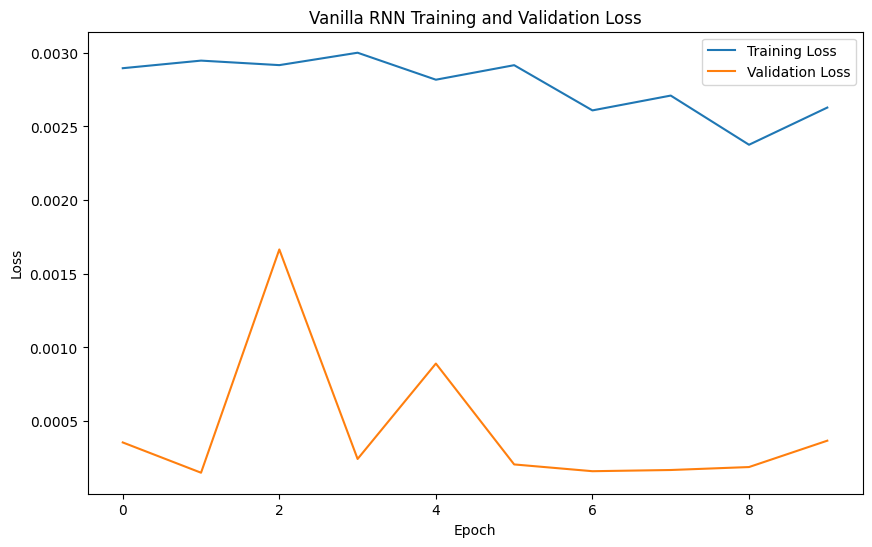

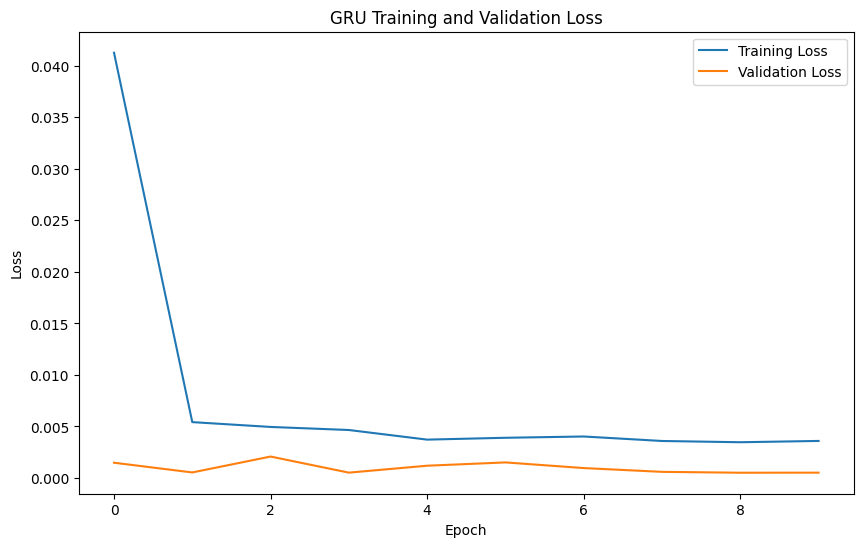

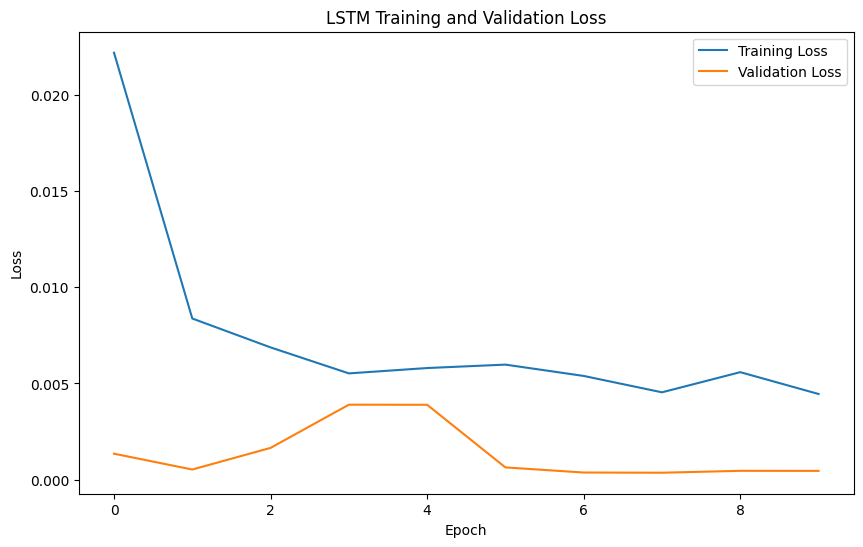

In [266]:
# 7. Plotting Training and Validation Loss

def plot_history(history, model_name):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
# Plot for Vanilla RNN
plot_history(history_rnn, 'Vanilla RNN')

# Plot for GRU
plot_history(history_gru, 'GRU')

# Plot for LSTM
plot_history(history_lstm, 'LSTM')


In [267]:
# Initialize empty lists for test sequences and targets
X_test = []
y_test = []

# Parameters for testing
N_test = 10  # Number of past days to consider
M_test = 1   # Number of future days to predict

# Step 1: Extract the last N_test days from the training data
last_N_test_days = scaled_train[-N_test:]  # Shape: (10, 5)

# Step 2: Combine with test data
test_data_extended = np.concatenate((last_N_test_days, scaled_test), axis=0)  # Shape: (30, 5)

# Verify shapes
print(f"\nShape of last_N_test_days: {last_N_test_days.shape}")
print(f"Shape of scaled_test: {scaled_test.shape}")
print(f"Shape of test_data_extended: {test_data_extended.shape}")




Shape of last_N_test_days: (10, 5)
Shape of scaled_test: (20, 5)
Shape of test_data_extended: (30, 5)


In [268]:
# Step 3: Create input (X_test) and target (y_test) sequences
for i in range(len(scaled_test)):
    # Each X_test is a sequence of N_test days
    X_sequence = test_data_extended[i:i + N_test]

    # Check if the sequence has the correct shape
    if X_sequence.shape[0] == N_test:
        X_test.append(X_sequence)
    else:
        print(f"Skipping sequence {i} due to insufficient data.")

    # Each y_test is the 'Close' price on the day after the sequence
    y_target = scaled_test[i, 3]  # 'Close' is the 4th column (index 3)
    y_test.append(y_target)

# Convert lists to numpy arrays
X_test = np.array(X_test)  # Expected Shape: (20, 10, 5)
y_test = np.array(y_test)  # Expected Shape: (20,)

# Verify the shapes
print(f"\nPrepared Test Sequences:")
print(f"X_test shape: {X_test.shape}")  # Should be (20, 10, 5)
print(f"y_test shape: {y_test.shape}")  # Should be (20,)




Prepared Test Sequences:
X_test shape: (20, 10, 5)
y_test shape: (20,)


In [269]:
# Load the best trained models
best_rnn = load_model('best_rnn_model.keras')
best_gru = load_model('best_gru_model.keras')
best_lstm = load_model('best_lstm_model.keras')

print("\nBest models loaded successfully.")

# Make predictions using each model
predictions_rnn = best_rnn.predict(X_test)
predictions_gru = best_gru.predict(X_test)
predictions_lstm = best_lstm.predict(X_test)

# Flatten the predictions to 1D arrays
predictions_rnn = predictions_rnn.flatten()  # Shape: (20,)
predictions_gru = predictions_gru.flatten()
predictions_lstm = predictions_lstm.flatten()

print("\nPredictions made successfully.")



Best models loaded successfully.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step

Predictions made successfully.


In [270]:
# Function to inverse scale 'Close' price
def inverse_scale(close_scaled, scaler):
    """
    Inverse scales the 'Close' price using the provided scaler.

    Parameters:
    - close_scaled: numpy array of scaled 'Close' prices.
    - scaler: fitted MinMaxScaler object.

    Returns:
    - close_original: numpy array of original 'Close' prices.
    """
    # Create a dummy array with zeros
    dummy = np.zeros((len(close_scaled), len(feature_cols)))

    # Assign the scaled 'Close' prices to the appropriate column
    dummy[:, 3] = close_scaled  # 'Close' is at index 3

    # Inverse transform to original scale
    close_original = scaler.inverse_transform(dummy)[:, 3]

    return close_original

In [271]:
# Inverse scale the predictions
pred_rnn_inv = inverse_scale(predictions_rnn, scaler)
pred_gru_inv = inverse_scale(predictions_gru, scaler)
pred_lstm_inv = inverse_scale(predictions_lstm, scaler)

print("\nInverse scaling of predictions completed.")

# Actual 'Close' prices from the test set
actual_close = test_df['Close'].values.astype(float)

# Adjust actual_close to match the number of predictions
actual_close_adjusted = actual_close[:len(pred_rnn_inv)]




Inverse scaling of predictions completed.


# Evaluation of Metrics for the all models

In [272]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

# Calculate evaluation metrics for Vanilla RNN
mse_rnn = mean_squared_error(actual_close_adjusted, pred_rnn_inv)
rmse_rnn = np.sqrt(mse_rnn)
mae_rnn = mean_absolute_error(actual_close_adjusted, pred_rnn_inv)

# Calculate evaluation metrics for GRU
mse_gru = mean_squared_error(actual_close_adjusted, pred_gru_inv)
rmse_gru = np.sqrt(mse_gru)
mae_gru = mean_absolute_error(actual_close_adjusted, pred_gru_inv)

# Calculate evaluation metrics for LSTM
mse_lstm = mean_squared_error(actual_close_adjusted, pred_lstm_inv)
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(actual_close_adjusted, pred_lstm_inv)



In [273]:
# Compile evaluation metrics into a DataFrame
metrics = {
    'Model': ['Vanilla RNN', 'GRU', 'LSTM'],
    'MSE': [mse_rnn, mse_gru, mse_lstm],
    'RMSE': [rmse_rnn, rmse_gru, rmse_lstm],
    'MAE': [mae_rnn, mae_gru, mae_lstm]
}

metrics_df = pd.DataFrame(metrics)
print("\nComparison of Model Performance:")
print(metrics_df)



Comparison of Model Performance:
         Model         MSE       RMSE        MAE
0  Vanilla RNN   67.875318   8.238648   6.223219
1          GRU  403.307587  20.082519  18.592156
2         LSTM  423.603593  20.581632  16.669814


In [274]:
def plot_model_predictions(actual, predicted, model_name):
    """
    Plots the actual vs. predicted 'Close' prices for a given model.

    Parameters:
    - actual (numpy array): Actual 'Close' prices.
    - predicted (numpy array): Predicted 'Close' prices from the model.
    - model_name (str): Name of the model (e.g., 'Vanilla RNN').
    """
    plt.figure(figsize=(10,5))
    plt.plot(actual, label='Actual Close Price', color='black', marker='o')
    plt.plot(predicted, label=f'{model_name} Predicted Close Price', color='blue', marker='x')
    plt.title(f'Actual vs. {model_name} Predicted Close Prices')
    plt.xlabel('Time (Days)')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



# Predicting and Evaluating the  closing price of stock by using the following models:
1. Vanilla RNN
2. GRU Model
3. LSTM Model

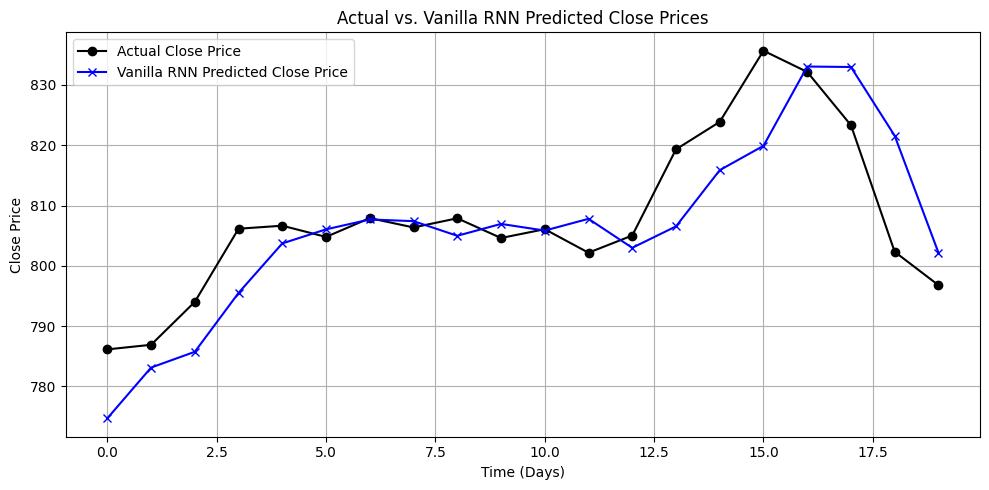

In [278]:
# Plot for Vanilla RNN
plt.figure(figsize=(10,5))
plt.plot(actual_close_adjusted, label='Actual Close Price', color='black', marker='o')
plt.plot(pred_rnn_inv, label='Vanilla RNN Predicted Close Price', color='blue', marker='x')
plt.title('Actual vs. Vanilla RNN Predicted Close Prices')
plt.xlabel('Time (Days)')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




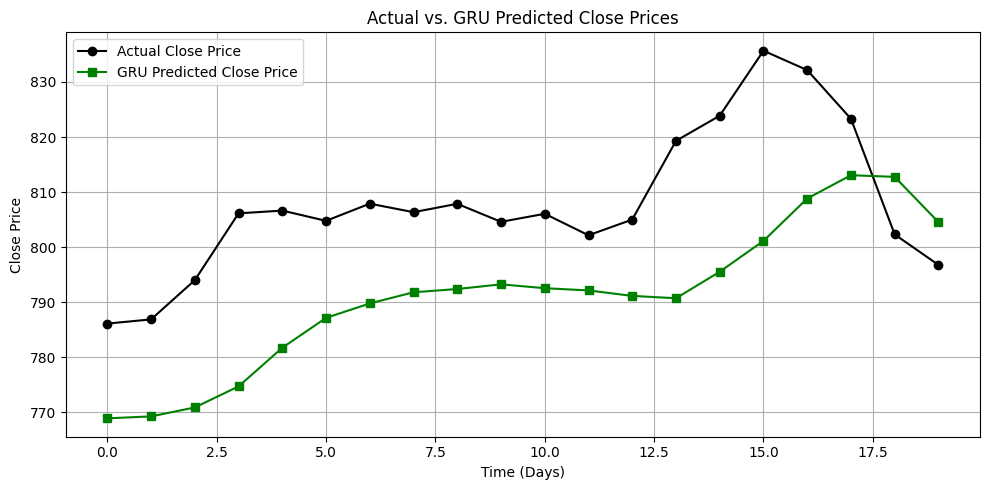

In [279]:
# Plot for GRU
plt.figure(figsize=(10,5))
plt.plot(actual_close_adjusted, label='Actual Close Price', color='black', marker='o')
plt.plot(pred_gru_inv, label='GRU Predicted Close Price', color='green', marker='s')
plt.title('Actual vs. GRU Predicted Close Prices')
plt.xlabel('Time (Days)')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

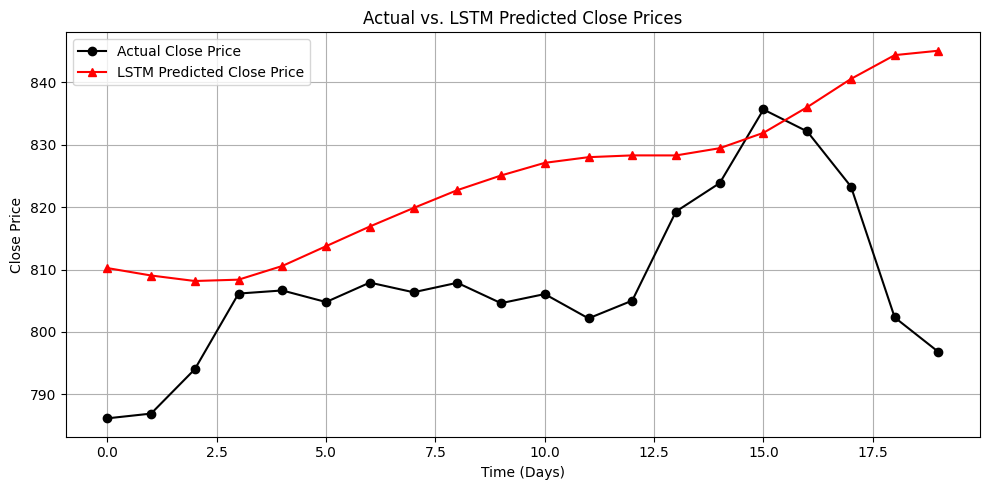

In [280]:
# Plot for LSTM
plt.figure(figsize=(10,5))
plt.plot(actual_close_adjusted, label='Actual Close Price', color='black', marker='o')
plt.plot(pred_lstm_inv, label='LSTM Predicted Close Price', color='red', marker='^')
plt.title('Actual vs. LSTM Predicted Close Prices')
plt.xlabel('Time (Days)')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()